# **Hands On Graph Neural Networks Using Python  -  CHAPTER 13**

- This script demonstrates the implementation and evaluation of temporal `Graph Neural Networks (GNNs)` using PyTorch Geometric Temporal on two datasets: WikiMaths and EnglandCovid.

- It includes data loaders for each dataset to prepare and visualize the data. The script defines various `GNN models (EvolveGCNH, EvolveGCNO, and MPNNLSTM)` and a common `Trainer` class for training and evaluating these models.

- The training process involves fitting the model on the training data, evaluating performance using `Mean Squared Error (MSE)` on the test data, and plotting predictions and regression results.

- The code sets a random seed for reproducibility, initializes, trains, and evaluates the models, and visualizes the results for both datasets.

In [5]:
# !pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install -q torch-geometric-temporal==0.54.0

import torch
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import EvolveGCNH, EvolveGCNO, MPNNLSTM
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader, EnglandCovidDatasetLoader

### **WikiMaths Data Loader Class**

 This class loads the WikiMaths dataset and prepares it for temporal graph analysis. It splits the dataset into training and testing sets and creates a DataFrame that stores the mean and standard deviation of node features over time. The plot_data method visualizes this data, including a moving average and a shaded region representing the standard deviation.

In [6]:
class WikiMathsDataLoader:
    def __init__(self):
        self.dataset = WikiMathsDatasetLoader().get_dataset()
        self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio=0.5)
        self.df = self._prepare_dataframe()

    def _prepare_dataframe(self):
        mean_cases = [snapshot.y.mean().item() for snapshot in self.dataset]
        std_cases = [snapshot.y.std().item() for snapshot in self.dataset]
        df = pd.DataFrame(mean_cases, columns=['mean'])
        df['std'] = pd.DataFrame(std_cases, columns=['std'])
        df['rolling'] = df['mean'].rolling(7).mean()
        return df

    def plot_data(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.df['mean'], 'k-', label='Mean')
        plt.plot(self.df['rolling'], 'g-', label='Moving average')
        plt.grid(linestyle=':')
        plt.fill_between(self.df.index, self.df['mean'] - self.df['std'], self.df['mean'] + self.df['std'], color='r', alpha=0.1)
        plt.axvline(x=360, color='b', linestyle='--')
        plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
        plt.xlabel('Time (days)')
        plt.ylabel('Normalized number of visits')
        plt.legend(loc='upper right')
        plt.show()

### **England Covid Data Loader Class**

This class is similar to WikiMathsDataLoader but works with the EnglandCovid dataset. It also splits the dataset into training and testing sets and creates a DataFrame for mean and standard deviation values. The plot_data method visualizes these statistics and marks the train/test split.

In [7]:
class EnglandCovidDataLoader:
    def __init__(self):
        self.dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)
        self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio=0.8)
        self.df = self._prepare_dataframe()

    def _prepare_dataframe(self):
        mean_cases = [snapshot.y.mean().item() for snapshot in self.dataset]
        std_cases = [snapshot.y.std().item() for snapshot in self.dataset]
        df = pd.DataFrame(mean_cases, columns=['mean'])
        df['std'] = pd.DataFrame(std_cases, columns=['std'])
        return df

    def plot_data(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.df['mean'], 'k-')
        plt.grid(linestyle=':')
        plt.fill_between(self.df.index, self.df['mean'] - self.df['std'], self.df['mean'] + self.df['std'], color='r', alpha=0.1)
        plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
        plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
        plt.xlabel('Reports')
        plt.ylabel('Mean normalized number of cases')
        plt.legend(loc='upper right')
        plt.show()

### **Temporal GNN model class with WikiMaths**

This class defines a temporal GNN model using the EvolveGCNH layer. It processes graph data by applying a recurrent graph convolution layer followed by a linear layer. The model is designed to capture temporal patterns in the WikiMaths dataset.

In [8]:
class TemporalGNNWikiMaths(nn.Module):
    def __init__(self, node_count, dim_in):
        super(TemporalGNNWikiMaths, self).__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.linear = nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

### **TemporalGNN model class with EvolveGCNO**

This class implements a temporal GNN model using the EvolveGCNO layer. It processes graph data with a recurrent layer and a linear transformation. The model is tailored for the EnglandCovid dataset to capture temporal dependencies.

In [9]:
class TemporalGNNEnglandCovidEvolveGCNO(nn.Module):
    def __init__(self, dim_in):
        super(TemporalGNNEnglandCovidEvolveGCNO, self).__init__()
        self.recurrent = EvolveGCNO(dim_in, 1)
        self.linear = nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

### **TemporalGNN Model Class with MPNNLSTM**

This class features a temporal GNN model utilizing the MPNNLSTM layer. It incorporates LSTM-based message passing and dropout regularization, followed by a linear layer to produce predictions. This model is designed for handling complex temporal dependencies in the EnglandCovid dataset.

In [10]:
class TemporalGNNEnglandCovidMPNNLSTM(nn.Module):
    def __init__(self, dim_in, dim_h, num_nodes):
        super(TemporalGNNEnglandCovidMPNNLSTM, self).__init__()
        self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(2*dim_h + dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h

### **Trainer class**

The Trainer class manages the training and evaluation process for the GNN models. It handles model training over a specified number of epochs, evaluates performance using Mean Squared Error (MSE), and provides methods for making predictions and visualizing the results, including plotting predictions against actual data and regression plots.

In [29]:
class Trainer:
    def __init__(self, model, train_dataset, test_dataset):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        self.criterion = nn.MSELoss()

    def train(self, epochs):
        self.model.train()
        for epoch in tqdm(range(epochs)):
            for snapshot in self.train_dataset:
                y_pred = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                loss = self.criterion(y_pred, snapshot.y)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        snapshot_count = 0
        with torch.no_grad():
            for snapshot in self.test_dataset:
                y_pred = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                mse = self.criterion(y_pred, snapshot.y)
                total_loss += mse.item()
                snapshot_count += 1
        return total_loss / snapshot_count

    def predict(self):
        self.model.eval()
        y_preds = [self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in self.test_dataset]
        return y_preds

    def plot_prediction(self, df, y_preds):
        plt.figure(figsize=(10, 5), dpi=300)
        plt.plot(df['mean'], 'k-', label='Mean')
        plt.plot(range(len(df) - len(y_preds), len(df)), y_preds, 'r-', label='Prediction')
        plt.grid(linestyle=':')
        plt.fill_between(df.index, df['mean'] - df['std'], df['mean'] + df['std'], color='r', alpha=0.1)
        plt.axvline(x=len(df) - len(y_preds), color='b', linestyle='--')
        plt.text(len(df) - len(y_preds), 1.5, 'Train/test split', rotation=-90, color='b')
        plt.xlabel('Time (days)')
        plt.ylabel('Normalized number of visits')
        plt.legend(loc='upper right')
        plt.show()

    def plot_regression(self, test_dataset):
        y_pred = self.model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()
        plt.figure(figsize=(10, 5), dpi=300)
        sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.show()

### **Set random seed for reproducibility**

In [12]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### **Load data for WikiMathsDataset**

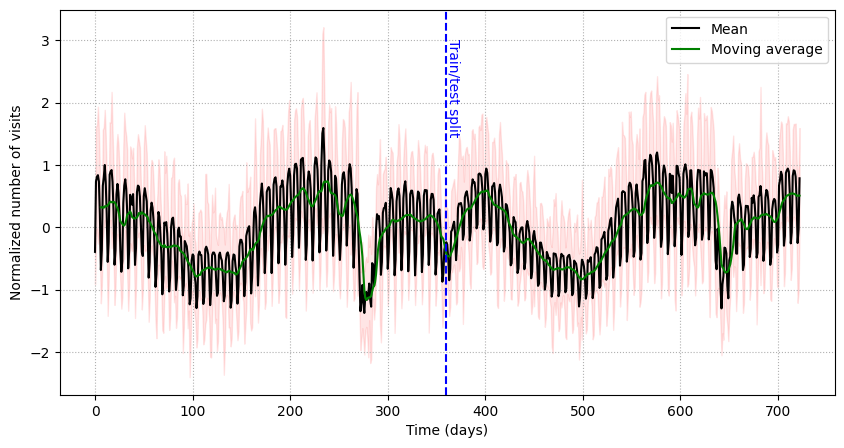

In [13]:
wiki_data_loader = WikiMathsDataLoader()
wiki_data_loader.plot_data()

### **Initialize and train model for WikiMathsDataset**

In [14]:
wiki_model = TemporalGNNWikiMaths(wiki_data_loader.dataset[0].x.shape[0], wiki_data_loader.dataset[0].x.shape[1])
wiki_trainer = Trainer(wiki_model, wiki_data_loader.train_dataset, wiki_data_loader.test_dataset)
wiki_trainer.train(epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1068])) that is different to the input size (torch.Size([1068, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 50/50 [04:45<00:00,  5.71s/it]


### **Evaluate prediction for WikiMathsDataset**

In [15]:
mse_loss = wiki_trainer.evaluate()
print(f'WikiMaths MSE = {mse_loss:.4f}')

WikiMaths MSE = 0.7893


### **plot prediction for WikiMathsDatase**

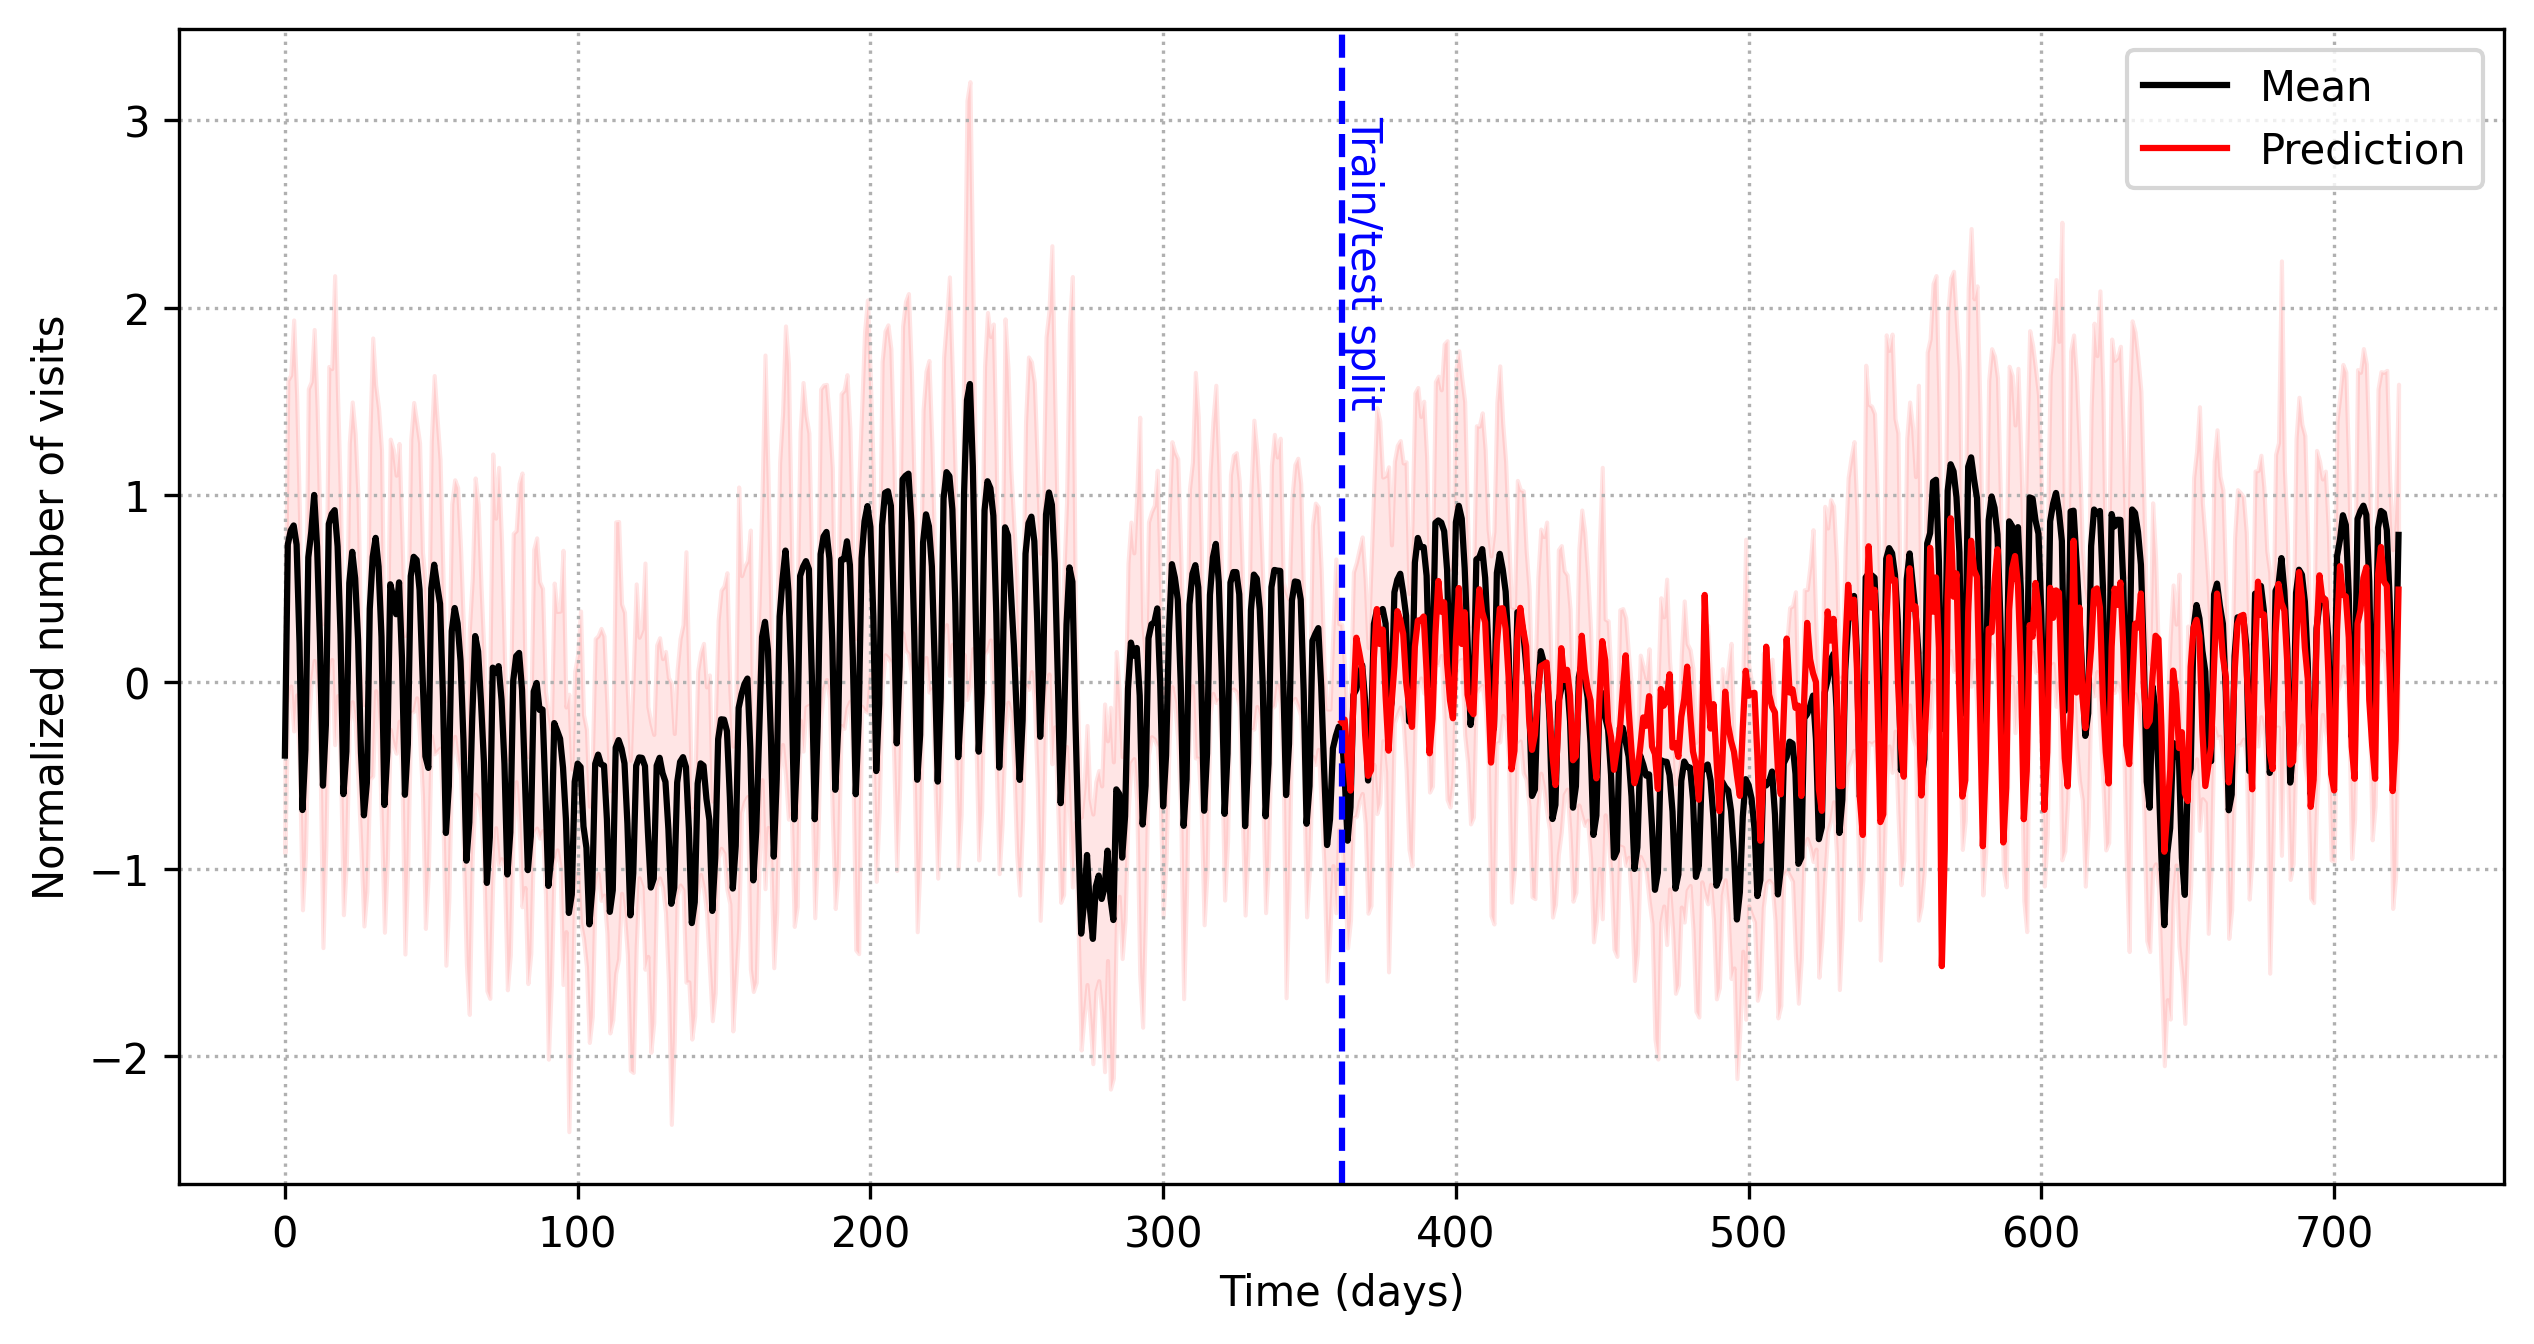

In [16]:
y_preds = wiki_trainer.predict()
wiki_trainer.plot_prediction(wiki_data_loader.df, y_preds)

### **plot Regression for WikiMathsDatase**

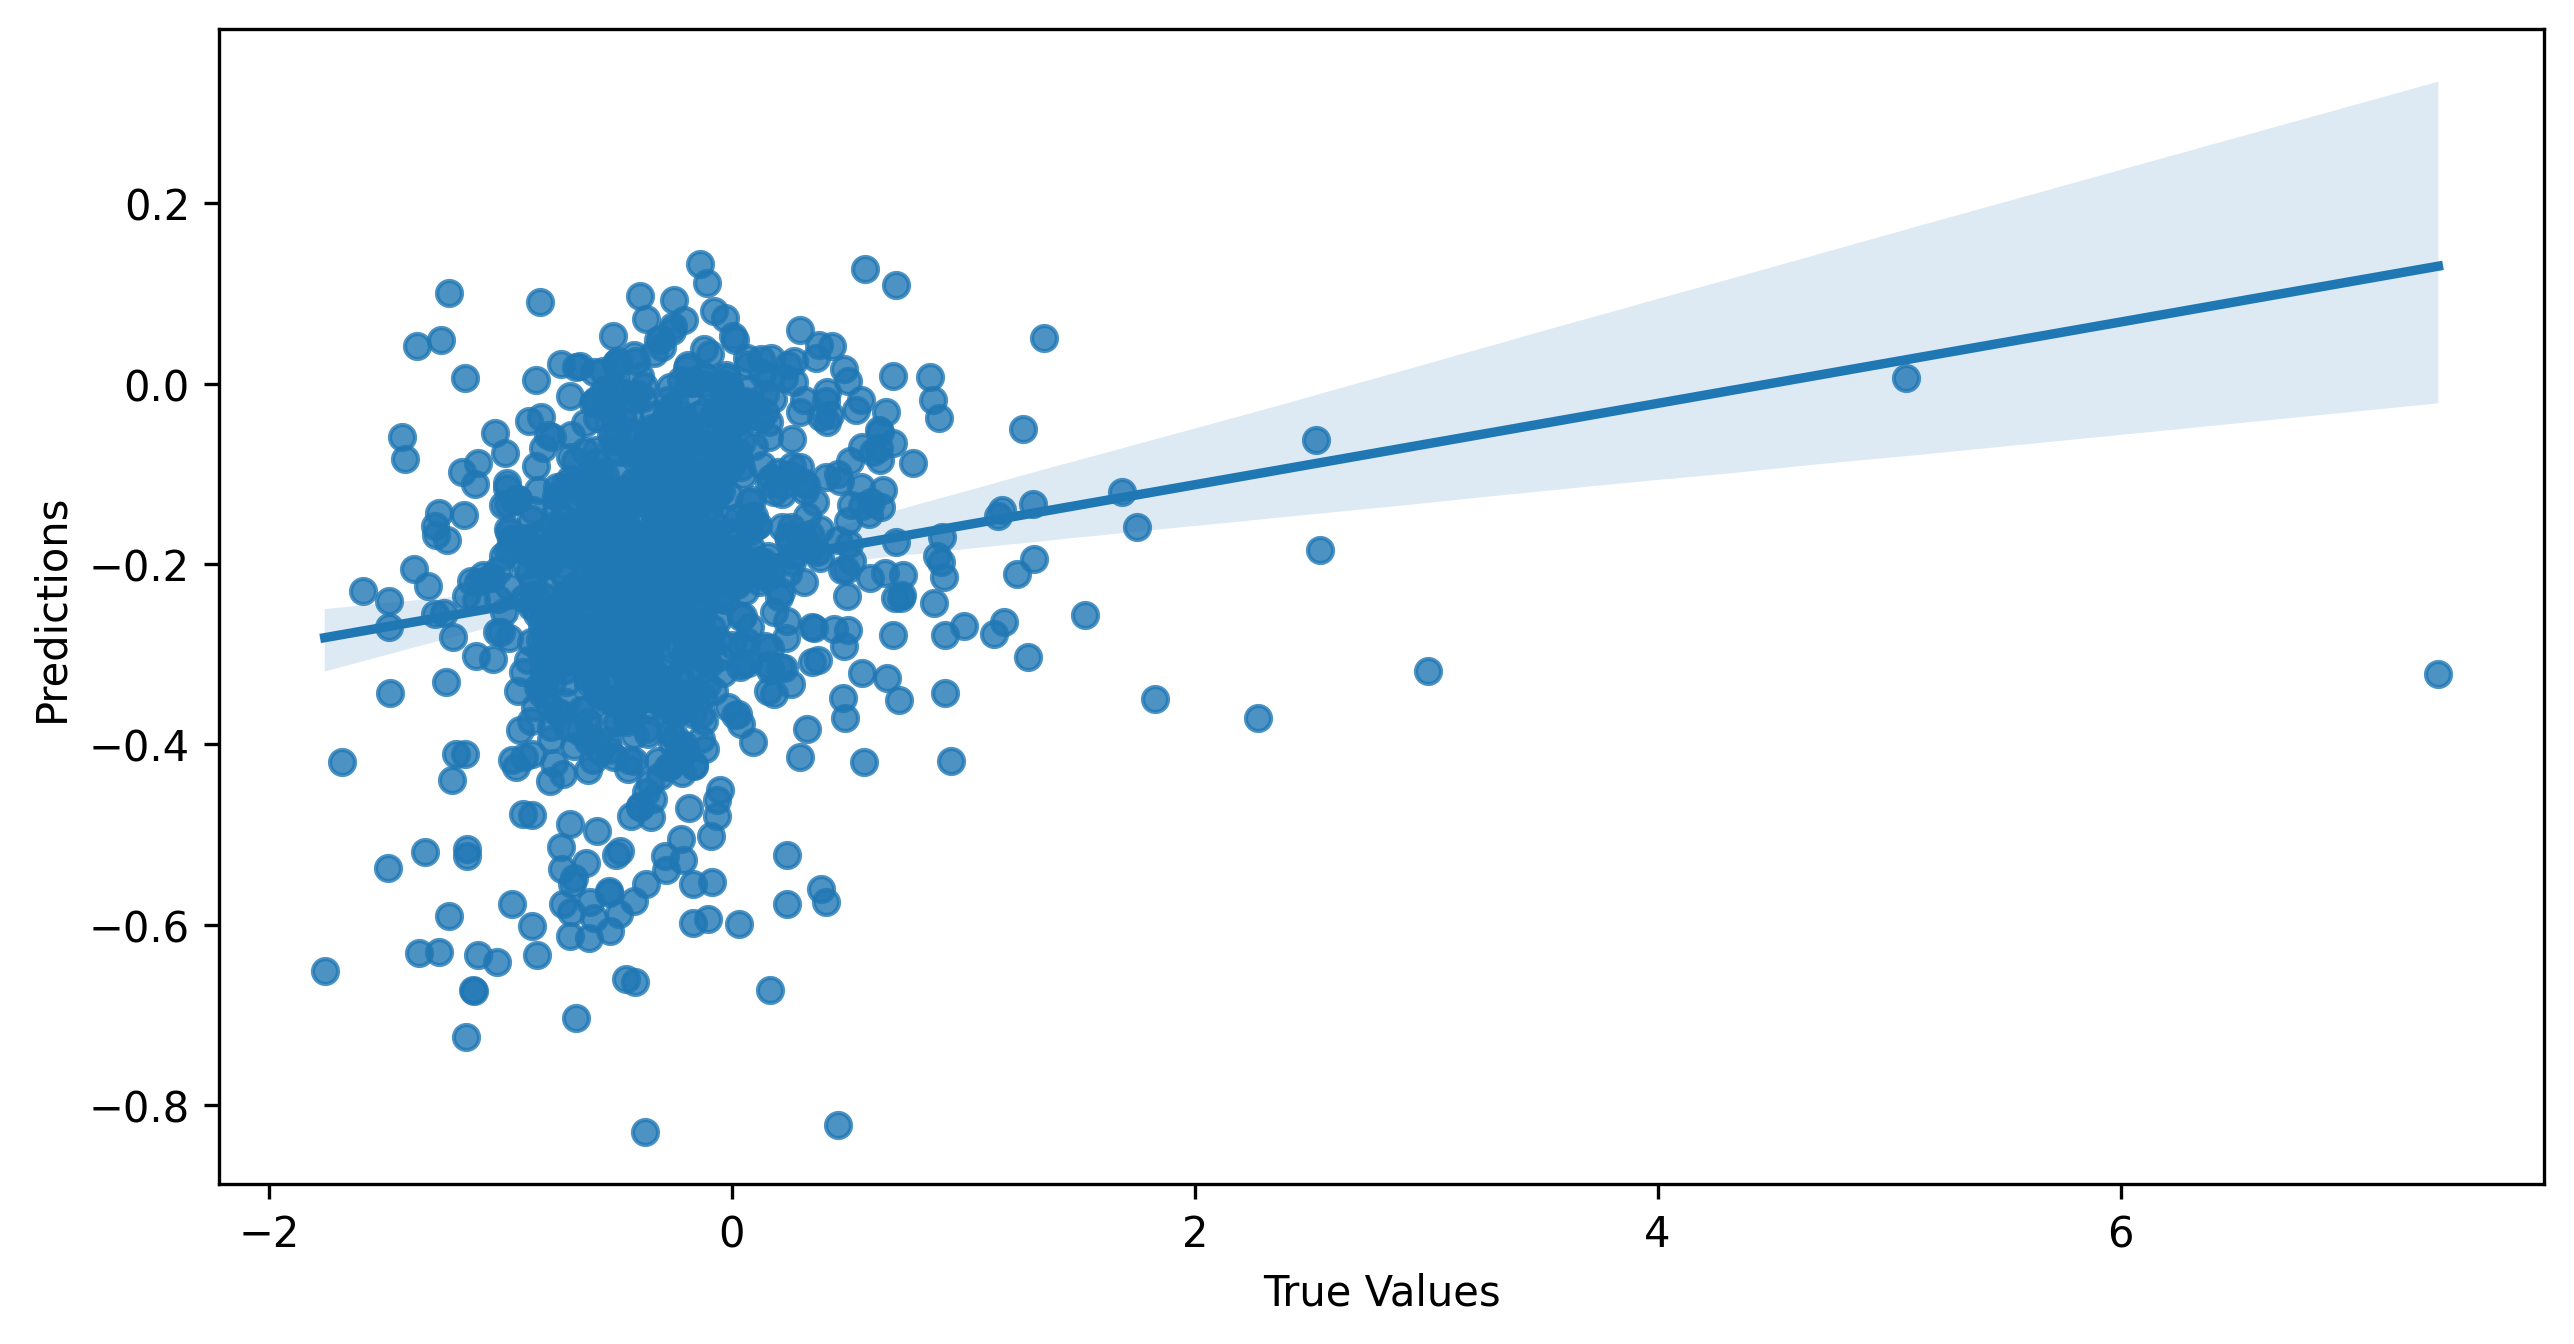

In [17]:
wiki_trainer.plot_regression(wiki_data_loader.test_dataset)

### **Load data for EnglandCovidDataset**

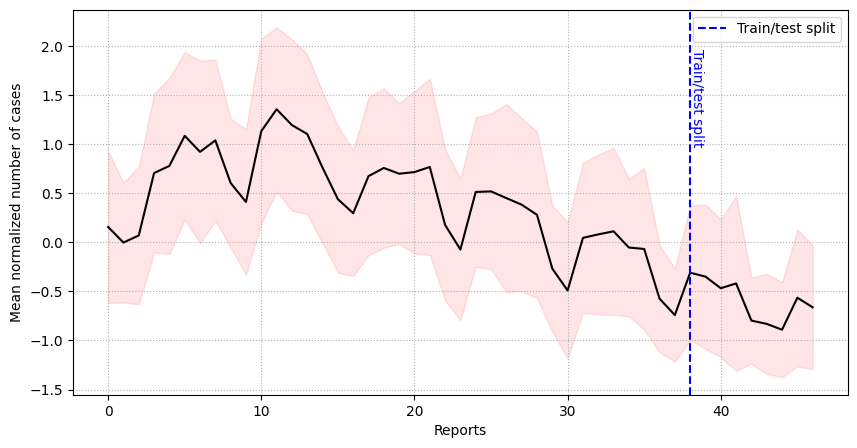

In [18]:
covid_data_loader = EnglandCovidDataLoader()
covid_data_loader.plot_data()

### **Initialize and train model for EnglandCovidDataset**

In [19]:
covid_model = TemporalGNNEnglandCovidEvolveGCNO(dim_in=covid_data_loader.dataset[0].x.shape[1])
covid_trainer = Trainer(covid_model, covid_data_loader.train_dataset, covid_data_loader.test_dataset)
covid_trainer.train(epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([129])) that is different to the input size (torch.Size([129, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


### **Evaluate for EnglandCovidDataset**

In [20]:
mse_loss = covid_trainer.evaluate()
print(f'EnglandCovid MSE = {mse_loss:.4f}')

EnglandCovid MSE = 0.8900


### **Plot Prediction for EnglandCovidDataset**

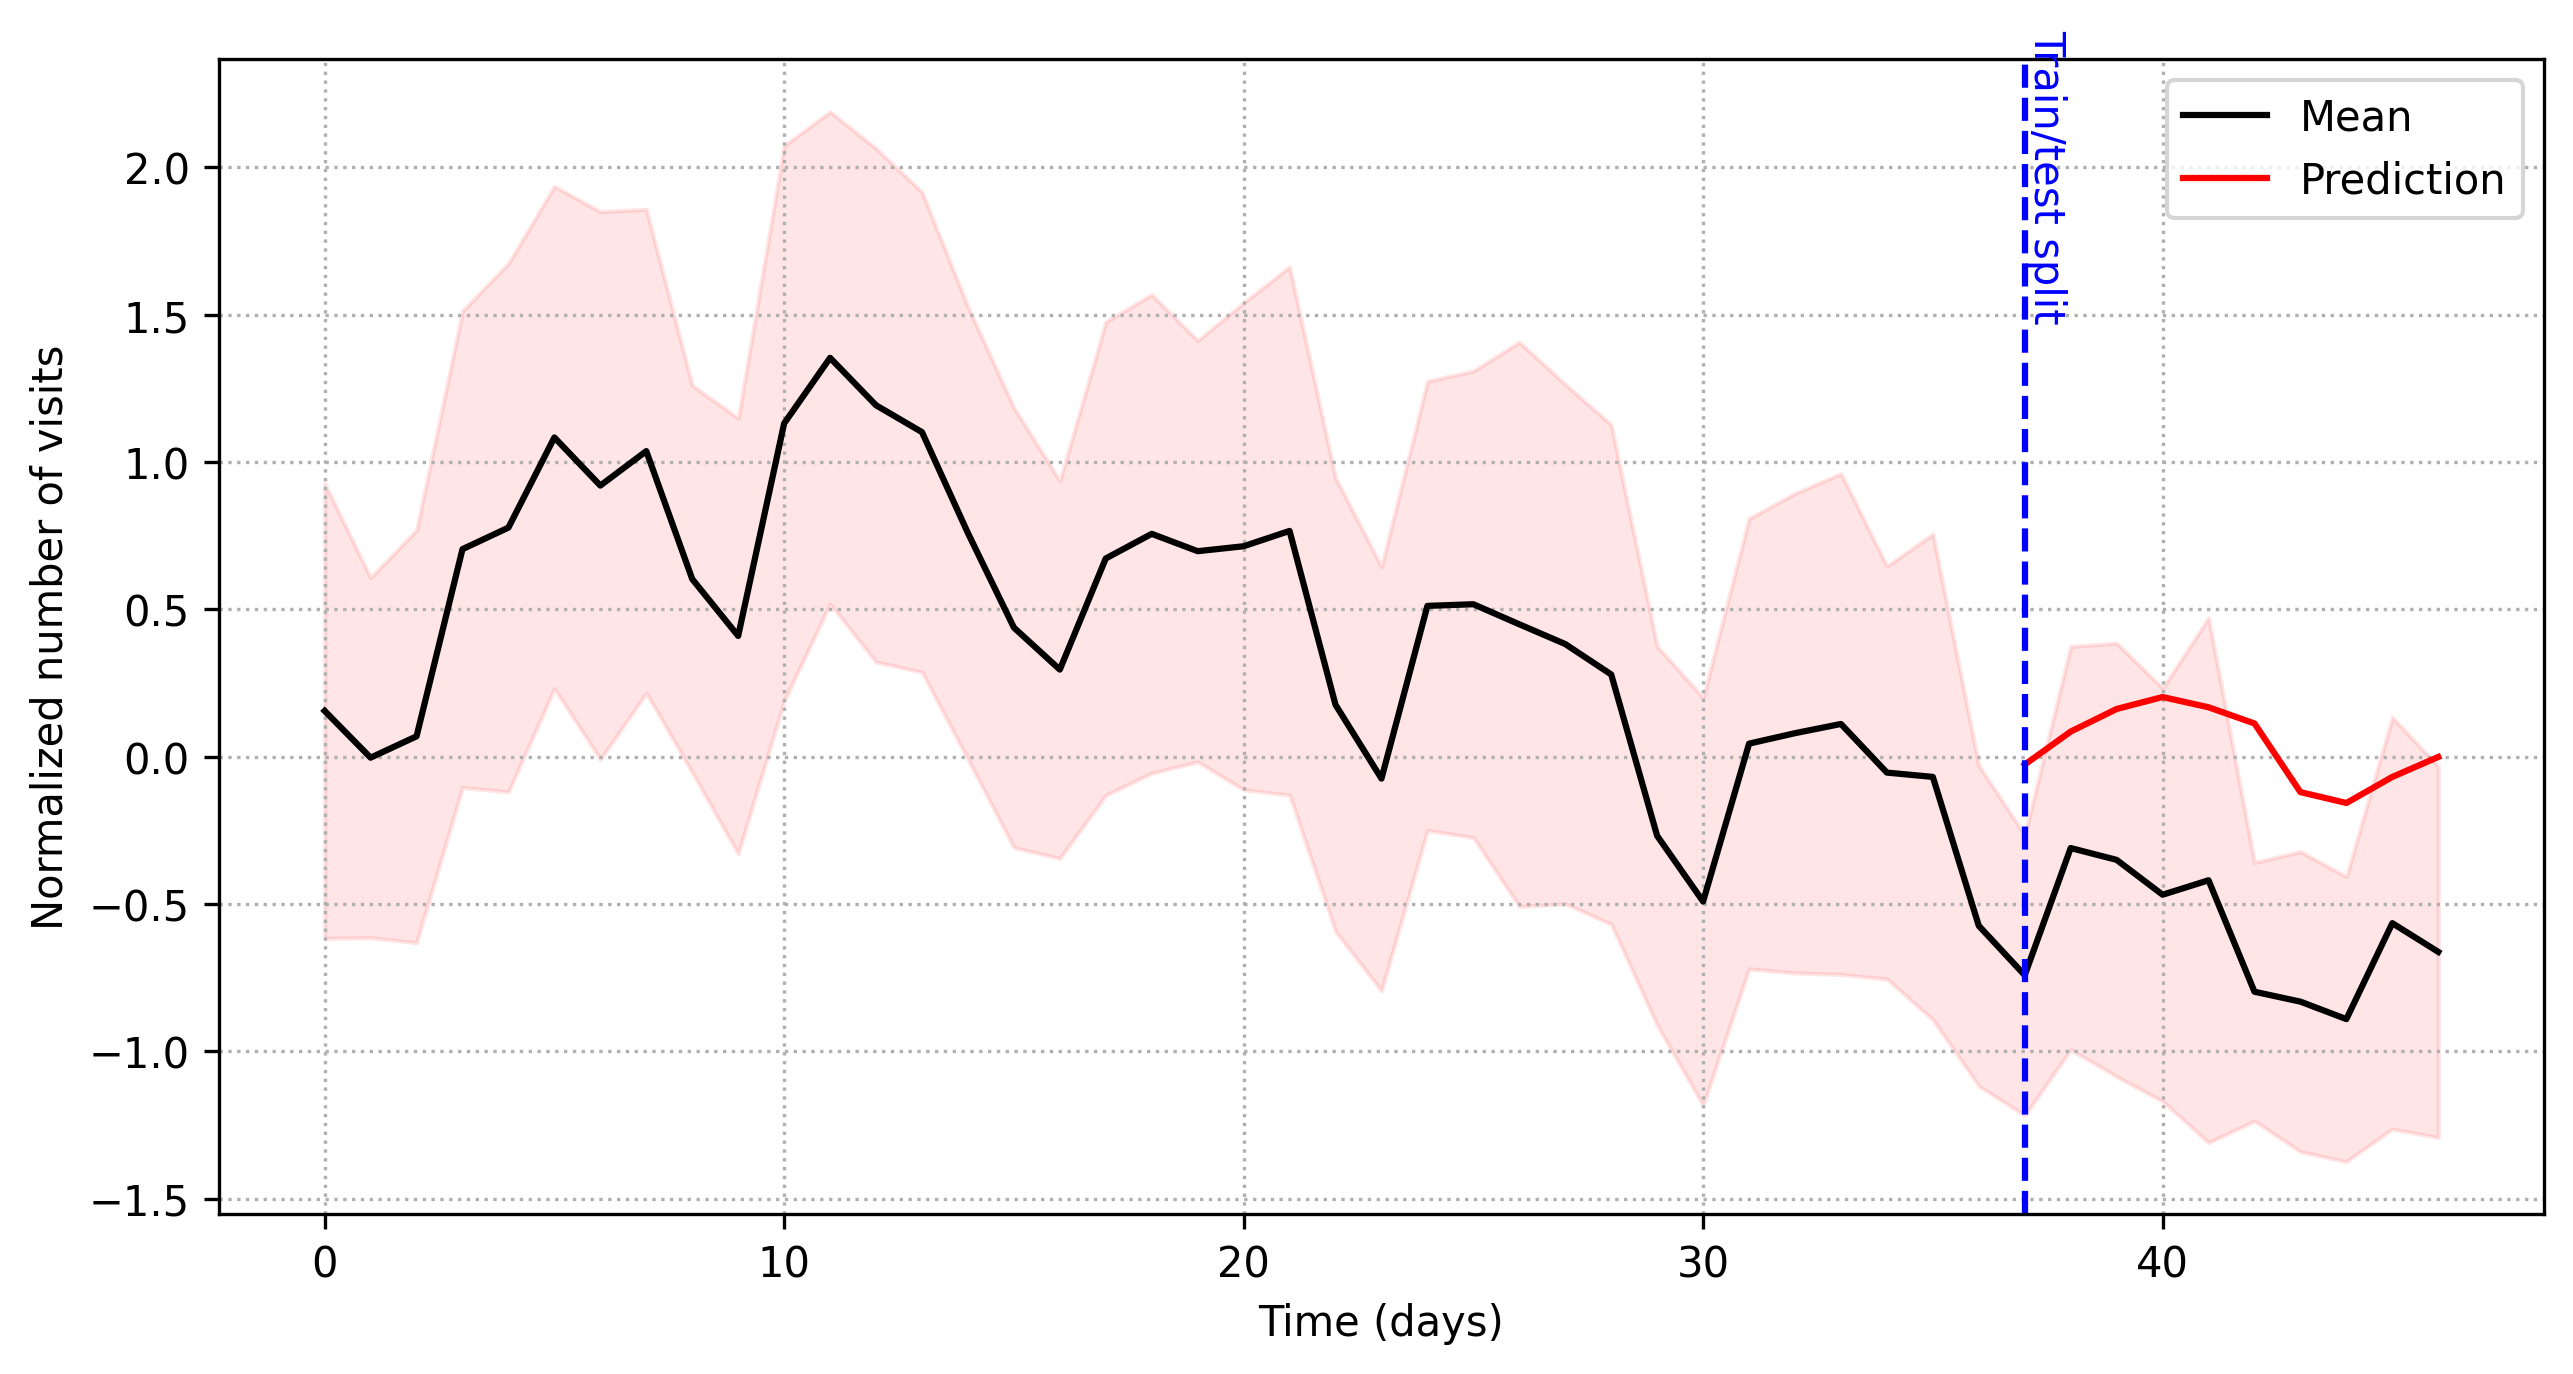

In [30]:
y_preds = covid_trainer.predict()
covid_trainer.plot_prediction(covid_data_loader.df, y_preds)

### **Plot Regression for EnglandCovidDataset**

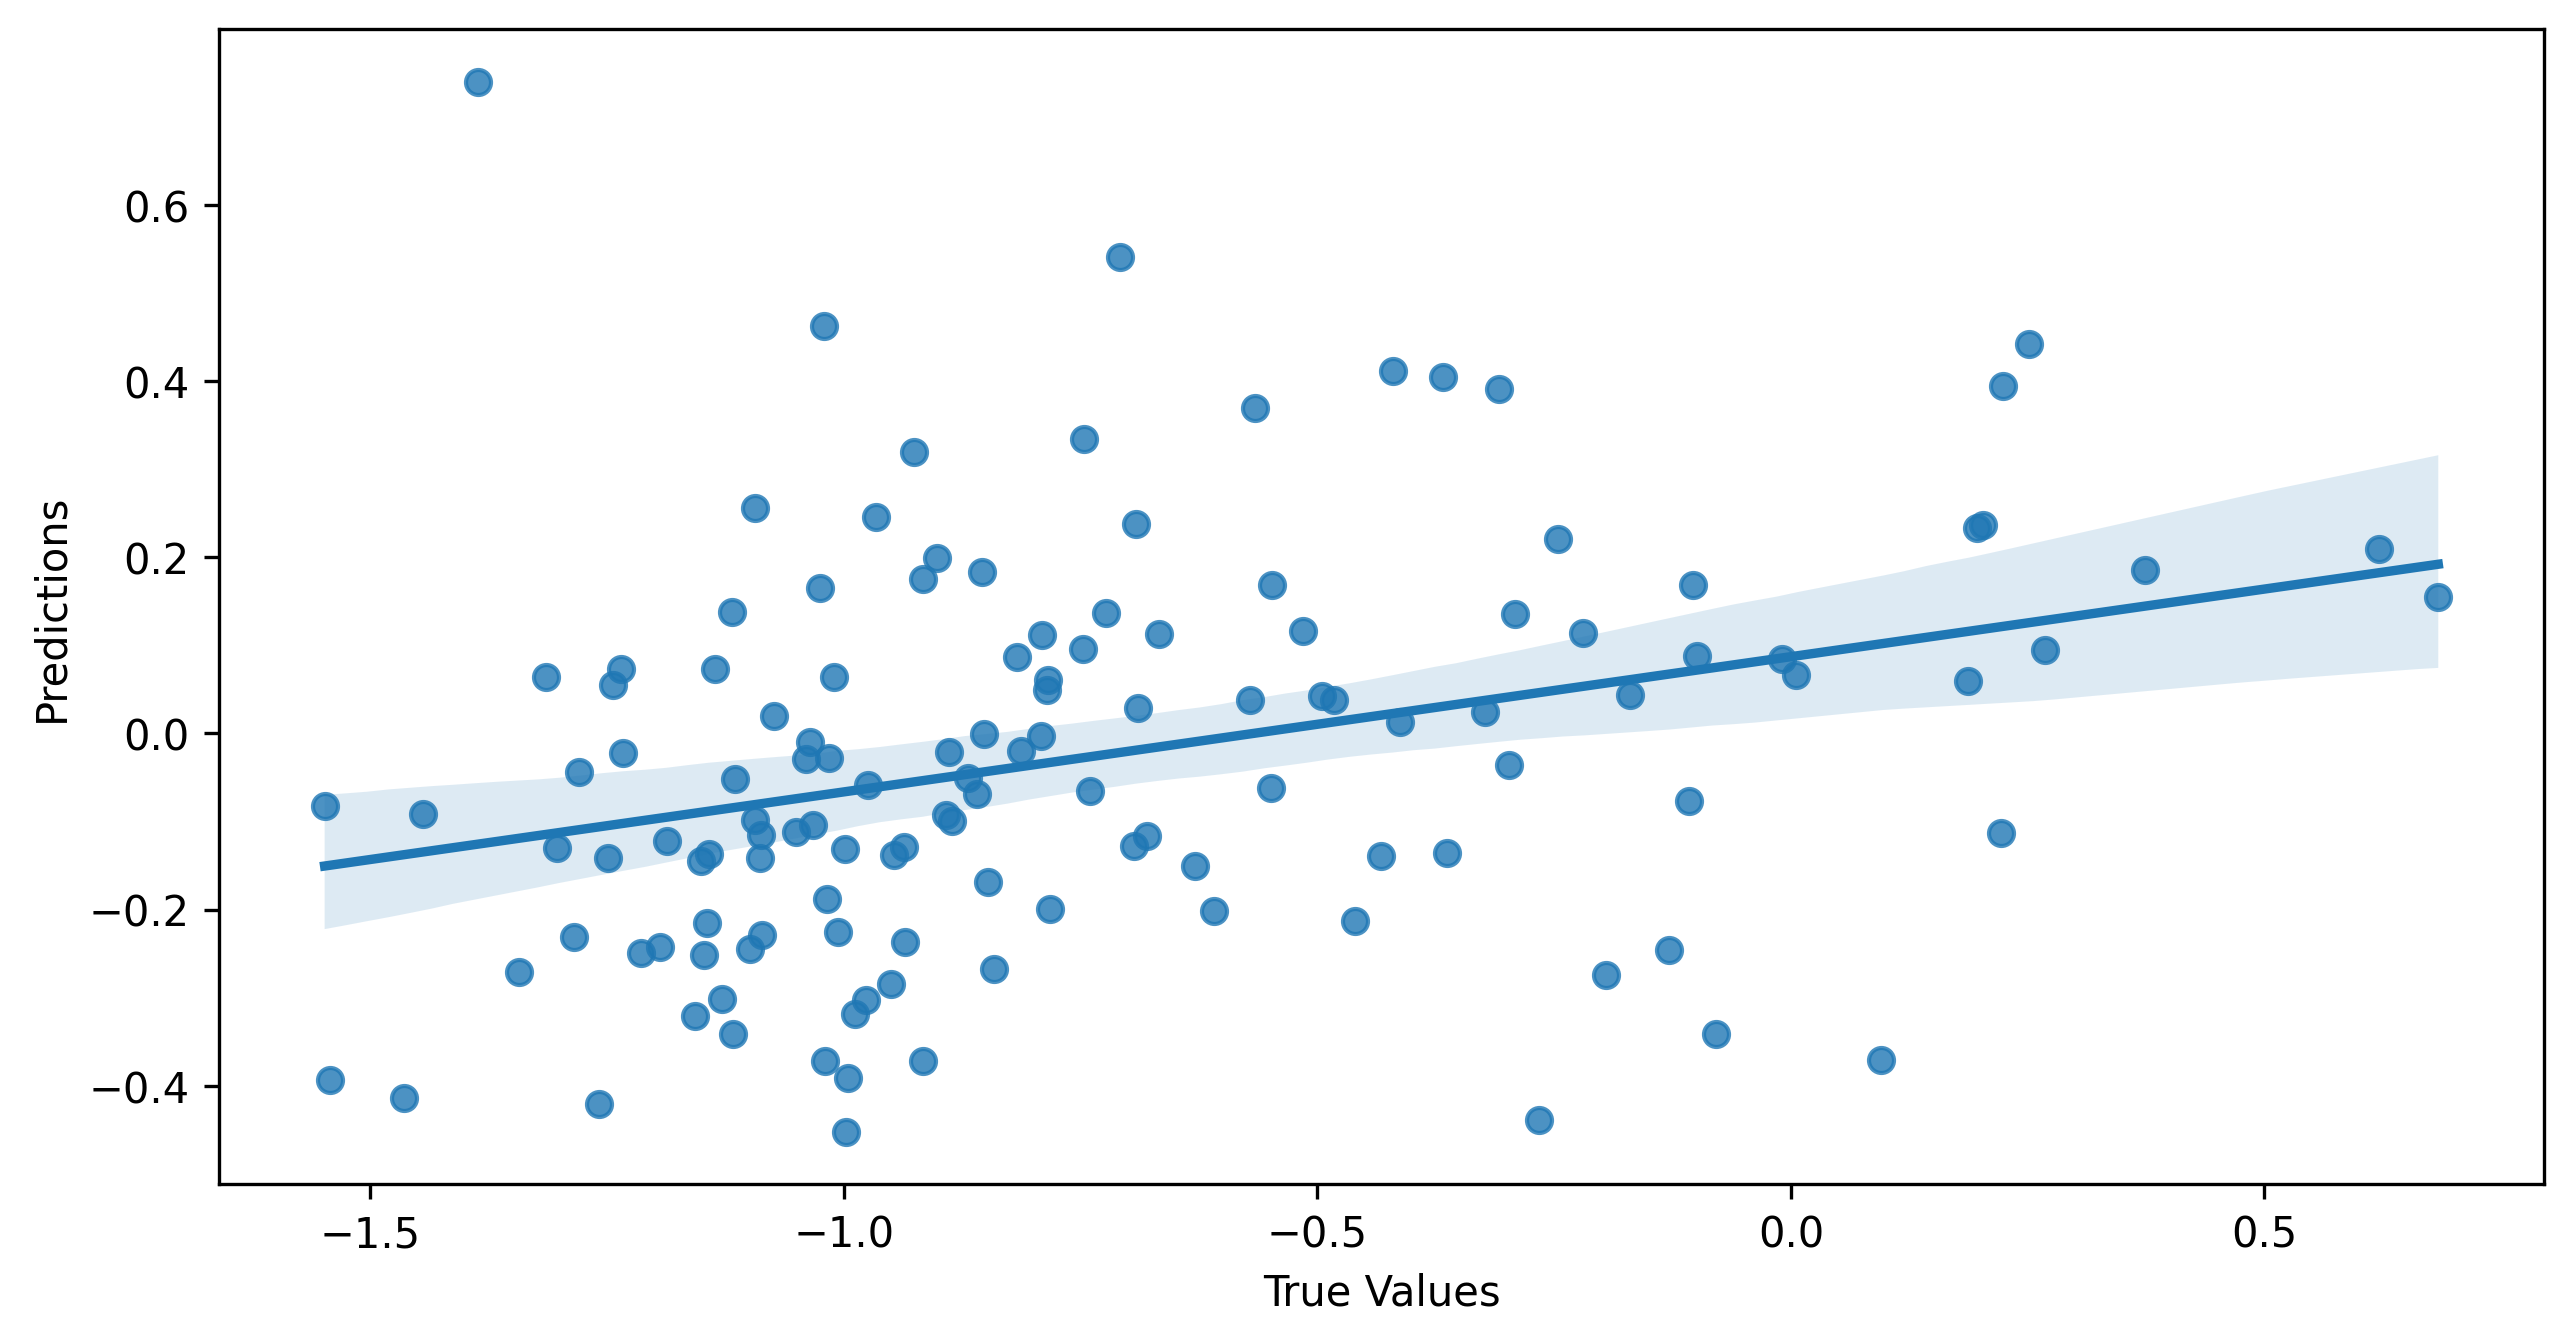

In [31]:
covid_trainer.plot_regression(covid_data_loader.test_dataset)